In [5]:
import sys
sys.path.append('../../')

In [6]:
import torch
import itertools
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.neighbors import KNeighborsClassifier
import pandas as pd
import numpy as np
from tqdm.auto import tqdm, trange

from models.train import train, test
from models.models import GCN, GAT, GraphSAGE, FNN
from models.utils import ContagionDataset, set_seed
from sklearn.metrics import matthews_corrcoef, mean_squared_error, mean_absolute_error

Using backend: pytorch


SyntaxError: invalid syntax (utils.py, line 442)

In [ ]:
def pretty(ld, indent=0):
    with open('result.txt', 'w', encoding='utf-8') as file:
        for d in tqdm(ld):
            file.write('{' + '\n')
            for key, value in d.items():
                file.write('\t' * (indent+1) + str(key) + ':' + str(value) + '\n')
                # file.write('\t' * (indent+1) + str(key) + '\n')
                # file.write('\t' * (indent+2) + str(value) + '\n')
            file.write('},\n')

In [ ]:
do_train = True

seed = 4444
set_seed(seed)

metric_filter_1 = 'val_mcc'
metric_filter_2 = 'test_mcc'

data_dir = '../data'
log_path = './logs'
save_path = './saved'

# Big dataset: Additional stress

In [ ]:
sets_lengths = (0.5, 0.25, 0.25)
target = 'additional_stress'

dataset = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    target = target,
)

out_feats = dataset.num_classes

In [ ]:
(dataset[0].ndata['train_mask']).sum()

tensor(750)

In [ ]:
(dataset[0].ndata['val_mask']).sum()

tensor(375)

In [ ]:
(dataset[0].ndata['test_mask']).sum()

tensor(375)

## Baseline

In [ ]:
dict_small_acc_train = {}
dict_small_acc_val = {}
dict_small_acc_test = {}
dict_small_rmse_train = {}
dict_small_rmse_val = {}
dict_small_rmse_test = {}
dict_small_mcc_train = {}
dict_small_mcc_val = {}
dict_small_mcc_test = {}

In [ ]:
# x_train,x_test,y_train,y_test = train_test_split(dataset.node_features[0].to_numpy(), dataset.targets[0], test_size=0.25, random_state=seed)
g_data = dataset.graphs[0].ndata
feats = g_data['feat']
labels = g_data['label']
train_mask = g_data['train_mask']
val_mask = g_data['val_mask']
test_mask = g_data['test_mask']

# train + val for training, test for test
x_train,x_test = feats[torch.logical_not(test_mask)], feats[test_mask]
y_train,y_test = labels[torch.logical_not(test_mask)], labels[test_mask]

In [ ]:
x_train.shape

torch.Size([1125, 4])

In [ ]:
x_test.shape

torch.Size([375, 4])

### Logistic Regression

In [14]:
model_lr = LogisticRegression(multi_class='multinomial',random_state=seed, max_iter=800).fit(x_train, y_train)
print(classification_report(y_true=y_test, y_pred=model_lr.predict(x_test)))

              precision    recall  f1-score   support

           0       0.76      0.60      0.67        98
           1       0.21      0.05      0.08        95
           2       0.34      0.53      0.41        93
           3       0.55      0.79      0.65        89

    accuracy                           0.49       375
   macro avg       0.46      0.49      0.45       375
weighted avg       0.46      0.49      0.45       375



In [15]:
dict_small_acc_train['logistic_regression'] = model_lr.score(x_train, y_train)
dict_small_acc_test['logistic_regression'] = model_lr.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['logistic_regression']}")
print(f"Test accuracy: {dict_small_acc_test['logistic_regression']}")

dict_small_rmse_train['logistic_regression'] = mean_squared_error(y_true=y_train,y_pred=model_lr.predict(x_train), squared=False)
dict_small_rmse_test['logistic_regression'] = mean_squared_error(y_true=y_test,y_pred=model_lr.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['logistic_regression']}")
print(f"Test rmse: {dict_small_rmse_test['logistic_regression']}")

dict_small_mcc_train['logistic_regression'] = matthews_corrcoef(y_true=y_train,y_pred=model_lr.predict(x_train))
dict_small_mcc_test['logistic_regression'] = matthews_corrcoef(y_true=y_test,y_pred=model_lr.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['logistic_regression']}")
print(f"Test mcc: {dict_small_mcc_test['logistic_regression']}")

Train accuracy: 0.496
Test accuracy: 0.488
Train rmse: 0.9688481133111974
Test rmse: 0.9605553948974868
Train mcc: 0.34443142561242607
Test mcc: 0.33524435059932634


### Random Forest

In [16]:
# # x_train_rf,x_val_rf,y_train_rf,y_val_rf = train_test_split(x_train, y_train, test_size=0.2, random_state=seed)
# x_train_rf,x_val_rf,x_test_rf = feats[train_mask], feats[val_mask], feats[test_mask]
# y_train_rf,y_val_rf,y_test_rf = labels[train_mask], labels[val_mask], labels[test_mask]
x_train_rf = x_train
y_train_rf = y_train
x_val_rf = x_test
y_val_rf = y_test

In [17]:
n = 20
num_nodes = x_train_rf.shape[0]
model_rf = None
val_acc = 0.0
for k in trange(1,num_nodes, (num_nodes - 1) // n):
    tmp = RandomForestClassifier(random_state=seed, n_estimators=k).fit(x_train_rf,y_train_rf)
    tmp_acc = matthews_corrcoef(y_true=y_val_rf,y_pred=tmp.predict(x_val_rf))
    if val_acc < tmp_acc:
        val_acc = tmp_acc
        model_rf = tmp

print(classification_report(y_true=y_test, y_pred=model_rf.predict(x_test)))

100%|██████████| 21/21 [00:24<00:00,  1.17s/it]

              precision    recall  f1-score   support

           0       0.68      0.70      0.69        98
           1       0.38      0.35      0.36        95
           2       0.31      0.30      0.31        93
           3       0.58      0.63      0.60        89

    accuracy                           0.50       375
   macro avg       0.49      0.50      0.49       375
weighted avg       0.49      0.50      0.49       375



In [18]:
model_rf

RandomForestClassifier(n_estimators=57, random_state=4444)

In [19]:
dict_small_acc_train['random_forest'] = model_rf.score(x_train_rf, y_train_rf)
dict_small_acc_val['random_forest'] = model_rf.score(x_val_rf, y_val_rf)
dict_small_acc_test['random_forest'] = model_rf.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['random_forest']}")
print(f"Val accuracy: {dict_small_acc_val['random_forest']}")
print(f"Test accuracy: {dict_small_acc_test['random_forest']}")

dict_small_rmse_train['random_forest'] = mean_squared_error(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf), squared=False)
dict_small_rmse_val['random_forest'] = mean_squared_error(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf), squared=False)
dict_small_rmse_test['random_forest'] = mean_squared_error(y_true=y_test,y_pred=model_rf.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['random_forest']}")
print(f"Val rmse: {dict_small_rmse_val['random_forest']}")
print(f"Test rmse: {dict_small_rmse_test['random_forest']}")

dict_small_mcc_train['random_forest'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_rf.predict(x_train_rf))
dict_small_mcc_val['random_forest'] = matthews_corrcoef(y_true=y_val_rf,y_pred=model_rf.predict(x_val_rf))
dict_small_mcc_test['random_forest'] = matthews_corrcoef(y_true=y_test,y_pred=model_rf.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['random_forest']}")
print(f"Val mcc: {dict_small_mcc_val['random_forest']}")
print(f"Test mcc: {dict_small_mcc_test['random_forest']}")

Train accuracy: 1.0
Val accuracy: 0.496
Test accuracy: 0.496
Train rmse: 0.0
Val rmse: 0.977070451229934
Test rmse: 0.977070451229934
Train mcc: 1.0
Val mcc: 0.3281549927912905
Test mcc: 0.3281549927912905


### KNN Classifier

In [19]:
model_knn = KNeighborsClassifier(n_neighbors=out_feats).fit(x_train,y_train)
print(classification_report(y_true=y_test, y_pred=model_knn.predict(x_test)))

              precision    recall  f1-score   support

           0       0.62      0.67      0.65        98
           1       0.25      0.27      0.26        95
           2       0.26      0.27      0.26        93
           3       0.45      0.34      0.38        89

    accuracy                           0.39       375
   macro avg       0.39      0.39      0.39       375
weighted avg       0.40      0.39      0.39       375



In [20]:
dict_small_acc_train['knn_classifier'] = model_knn.score(x_train_rf, y_train_rf)
dict_small_acc_test['knn_classifier'] = model_knn.score(x_test, y_test)
print(f"Train accuracy: {dict_small_acc_train['knn_classifier']}")
print(f"Test accuracy: {dict_small_acc_test['knn_classifier']}")

dict_small_rmse_train['knn_classifier'] = mean_squared_error(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf), squared=False)
dict_small_rmse_test['knn_classifier'] = mean_squared_error(y_true=y_test,y_pred=model_knn.predict(x_test), squared=False)
print(f"Train rmse: {dict_small_rmse_train['knn_classifier']}")
print(f"Test rmse: {dict_small_rmse_test['knn_classifier']}")

dict_small_mcc_train['knn_classifier'] = matthews_corrcoef(y_true=y_train_rf,y_pred=model_knn.predict(x_train_rf))
dict_small_mcc_test['knn_classifier'] = matthews_corrcoef(y_true=y_test,y_pred=model_knn.predict(x_test))
print(f"Train mcc: {dict_small_mcc_train['knn_classifier']}")
print(f"Test mcc: {dict_small_mcc_test['knn_classifier']}")

Train accuracy: 0.6328888888888888
Test accuracy: 0.392
Train rmse: 0.977070451229934
Test rmse: 1.1372481406154653
Train mcc: 0.5121440277091303
Test mcc: 0.18845797689767943


### FNN

In [3]:
save_model = f'{save_path}_fnn'
log_dir = f'{log_path}_fnn'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = False,
    target = target,
)

# fnn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[5, 10], [10, 15], [5,5,5], [5, 10, 15], [5, 10, 15, 20], [5], [10], [15]],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_nodes = [None, 'bn', 'gn'],
#     dropout=[0.2, 0.5, 0.0],
#     # other
#     lr=[1, 1e-1, 1e-2],
#     label_smoothing=[0.0, 0.2, 0.4],
# )

fnn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[10, 15], [10, 15, 20], [5, 10, 15], [15] * 2, [15] * 3],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_nodes = [None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
)
list_model = [dict(zip(fnn_model.keys(), k)) for k in itertools.product(*fnn_model.values())]

NameError: name 'save_path' is not defined

In [4]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')

        train(
            model=FNN(**d),
            dict_model=d,
            dataset_train=dataset_val,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=False,
        )

NameError: name 'do_train' is not defined

#### Results

In [23]:
res_edges_fnn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=False,
)

100%|██████████| 1193/1193 [01:12<00:00, 16.53it/s]


In [56]:
res_edges = res_edges_fnn
res_edges[0]

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.2582792,
 'train_acc': 0.5173333287239075,
 'val_acc': 0.48533332347869873,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '0.49_4_[10_15_20]_4_ReLU()_gn_0.2_0.1_adamw_max_val_mcc_0.2_False_False_0_80',
 'train_mcc': 0.38579769746701903,
 'val_mcc': 0.3604527033931331,
 'test_mcc': 0.40516614912661547,
 'train_rmse': 0.8809086218218096,
 'val_rmse': 0.9136009340333813,
 'test_rmse': 0.916515138991168,
 'test_acc': 0.5253333449363708}

In [57]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.2633945,
 'train_acc': 0.47466665506362915,
 'val_acc': 0.46133333444595337,
 'epoch': 60,
 'model_class': 'fnn',
 'path_name': '0.46_4_[10_15_20]_4_ReLU()_gn_0.2_0.1_adamw_max_val_mcc_0.2_False_False_0_60',
 'train_mcc': 0.38508205988952576,
 'val_mcc': 0.39268795467398016,
 'test_mcc': 0.37953226373308824,
 'train_rmse': 0.8633268983029159,
 'val_rmse': 0.8687155268939694,
 'test_rmse': 0.8988882021697693,
 'test_acc': 0.47200000286102295}

In [58]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': False,
 'train_self_loop': False,
 'train_drop_edges': 0,
 'train_loss': 1.2582792,
 'train_acc': 0.5173333287239075,
 'val_acc': 0.48533332347869873,
 'epoch': 80,
 'model_class': 'fnn',
 'path_name': '0.49_4_[10_15_20]_4_ReLU()_gn_0.2_0.1_adamw_max_val_mcc_0.2_False_False_0_80',
 'train_mcc': 0.38579769746701903,
 'val_mcc': 0.3604527033931331,
 'test_mcc': 0.40516614912661547,
 'train_rmse': 0.8809086218218096,
 'val_rmse': 0.9136009340333813,
 'test_rmse': 0.916515138991168,
 'test_acc': 0.5253333449363708}

In [59]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 1193/1193 [00:00<00:00, 29925.63it/s]


In [60]:
cm = all[sort_idx[0]]['test_cm'][0]

In [61]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

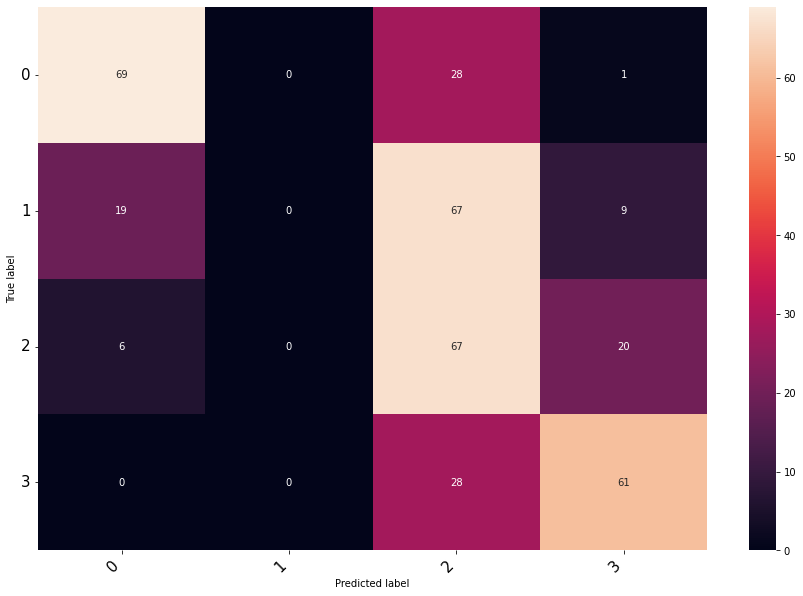

In [62]:
cm.visualize()

In [63]:
cm.class_accuracy

tensor([0.7041, 0.0000, 0.7204, 0.6854])

### Baseline Overall

In [28]:
print(dict_small_acc_train)
print(dict_small_acc_val)
print(dict_small_acc_test)

{'logistic_regression': 0.496, 'random_forest': 1.0, 'knn_classifier': 0.6328888888888888}
{'random_forest': 0.496}
{'logistic_regression': 0.488, 'random_forest': 0.496, 'knn_classifier': 0.392}


In [29]:
print(dict_small_mcc_train)
print(dict_small_mcc_val)
print(dict_small_mcc_test)

{'logistic_regression': 0.34443142561242607, 'random_forest': 1.0, 'knn_classifier': 0.5121440277091303}
{'random_forest': 0.3281549927912905}
{'logistic_regression': 0.33524435059932634, 'random_forest': 0.3281549927912905, 'knn_classifier': 0.18845797689767943}


In [30]:
print(dict_small_rmse_train)
print(dict_small_rmse_val)
print(dict_small_rmse_test)

{'logistic_regression': 0.9688481133111974, 'random_forest': 0.0, 'knn_classifier': 0.977070451229934}
{'random_forest': 0.977070451229934}
{'logistic_regression': 0.9605553948974868, 'random_forest': 0.977070451229934, 'knn_classifier': 1.1372481406154653}


### GCN

In [31]:
save_model = f'{save_path}_gcn'
log_dir = f'{log_path}_gcn'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gcn_model = dict(
    in_features=[len(dataset_val.node_attributes)],
    h_features=[[15] * 3, [10, 15, 20], [5, 10, 15, 20],],
    out_features=[dataset_val.num_classes],
    activation=[torch.nn.ReLU()],
    norm_edges=['both', 'none'],
    norm_nodes=[None, 'bn', 'gn'],
    dropout=[0.2, 0.0],
    # other
    lr=[1e-1],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True,],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gcn_model.keys(), k)) for k in itertools.product(*gcn_model.values())]

# gcn_model = dict(
#     in_features=[len(dataset_val.node_attributes)],
#     h_features=[[10] * 3],
#     out_features=[dataset_val.num_classes],
#     activation=[torch.nn.ReLU()],
#     norm_edges=['both', 'none'],
#     norm_nodes=[None, 'bn', 'gn'],
#     dropout=[0.2, 0.0],
#     # other
#     lr=[1],
#     label_smoothing=[0.0,],
#     use_edge_weight=[True, ],
#     drop_edges=[0,0.2],
# )
# list_model = [{i:j[k] for i,j in gcn_model.items()} for k in range(len(gcn_model['in_features']))]

In [32]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GCN(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [33]:
res_edges_gcn = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 2512/2512 [02:07<00:00, 19.66it/s]


In [34]:
res_edges = res_edges_gcn
res_edges[0]

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'bn',
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 1.7312635,
 'train_acc': 0.5199999809265137,
 'val_acc': 0.5226666927337646,
 'epoch': 30,
 'model_class': 'gcn',
 'path_name': '0.52_4_[5_10_15_20]_4_ReLU()_none_bn_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0.2_30',
 'train_mcc': 0.3687966255722127,
 'val_mcc': 0.3884798983961357,
 'test_mcc': 0.4180505037758314,
 'train_rmse': 0.8687155268939694,
 'val_rmse': 0.8702490065109717,
 'test_rmse': 0.8326663997864531,
 'test_acc': 0.5600000023841858}

In [35]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': None,
 'dropout': 0.0,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.9401753,
 'train_acc': 0.5093333125114441,
 'val_acc': 0.5413333177566528,
 'epoch': 18,
 'model_class': 'gcn',
 'path_name': '0.54_4_[10_15_20]_4_ReLU()_none_None_0.0_0.1_adamw_max_val_mcc_0.0_True_True_0',
 'train_mcc': 0.38843138123882154,
 'val_mcc': 0.4310004824315277,
 'test_mcc': 0.3998183352136604,
 'train_rmse': 0.9667816023625329,
 'val_rmse': 0.9549869109050658,
 'test_rmse': 0.9223159256278006,
 'test_acc': 0.5226666927337646}

In [36]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [5, 10, 15, 20],
 'out_features': 4,
 'activation': ReLU(),
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'dropout': 0.2,
 'train_lr': 0.1,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.5496266,
 'train_acc': 0.5066666603088379,
 'val_acc': 0.4906666576862335,
 'epoch': 20,
 'model_class': 'gcn',
 'path_name': '0.49_4_[5_10_15_20]_4_ReLU()_none_gn_0.2_0.1_adamw_max_val_mcc_0.0_True_True_0_20',
 'train_mcc': 0.3701886792552317,
 'val_mcc': 0.3705651396584429,
 'test_mcc': 0.43001101933745617,
 'train_rmse': 0.920869154657707,
 'val_rmse': 0.9106774035482232,
 'test_rmse': 0.920869154657707,
 'test_acc': 0.5440000295639038}

In [37]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 2512/2512 [00:00<00:00, 33099.89it/s]


### GraphSAGE

In [38]:
save_model = f'{save_path}_sage'
log_dir = f'{log_path}_sage'

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = True,
    target = target,
)

sage_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[20] * 3, [25] * 3, [15] * 3, [10], [20,25,20], [30] * 3], 
    out_features = [out_feats],
    # aggregator_type = ['mean', 'lstm'],
    aggregator_type = ['lstm'],
    norm_edges = ['right', 'none'],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    feat_drop = [0.2, 0],
    # other
    lr=[1e-2],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    add_self_loop=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(sage_model.keys(), k)) for k in itertools.product(*sage_model.values())]

# sage_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     h_features = [[30] * 3], 
#     out_features = [out_feats],
#     aggregator_type = ['lstm'],
#     norm_edges = ['none'],
#     norm_nodes = ['gn'],
#     activation = [torch.nn.ReLU()],
#     feat_drop = [0],
#     # other
#     lr=[1e-2],
#     label_smoothing=[0.0],
#     use_edge_weight=[True],
#     add_self_loop=[True],
#     drop_edges=[0],
# )
# list_model = [{i:j[k] for i,j in sage_model.items()} for k in range(len(sage_model['in_features']))]

In [39]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        add_self_loop = d.pop('add_self_loop')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        dataset_valid = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=0,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GraphSAGE(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_valid,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [40]:
res_edges_sage = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 6560/6560 [38:51<00:00,  2.81it/s] 


In [41]:
res_edges = res_edges_sage
res_edges[0]

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.3945291,
 'train_acc': 0.9413333535194397,
 'val_acc': 0.8399999737739563,
 'epoch': 71,
 'model_class': 'sage',
 'path_name': '0.84_4_[25_25_25]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_10_True_0.2',
 'train_mcc': 0.922015839251606,
 'val_mcc': 0.7866126651334473,
 'test_mcc': 0.8021669003460641,
 'train_rmse': 0.2732520204255893,
 'val_rmse': 0.40987803063838396,
 'test_rmse': 0.48166378315169184,
 'test_acc': 0.8506666421890259}

In [42]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [30, 30, 30],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.2,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 0.63557136,
 'train_acc': 0.9946666955947876,
 'val_acc': 0.8853333592414856,
 'epoch': 100,
 'model_class': 'sage',
 'path_name': '0.89_4_[30_30_30]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.2_True_10_True_0_100',
 'train_mcc': 0.9928968395426994,
 'val_mcc': 0.8475153433227356,
 'test_mcc': 0.7625404665801752,
 'train_rmse': 0.07302967433402215,
 'val_rmse': 0.35023801430836526,
 'test_rmse': 0.46475800154489,
 'test_acc': 0.8213333487510681}

In [43]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [25, 25, 25],
 'out_features': 4,
 'aggregator_type': 'lstm',
 'norm_edges': 'none',
 'norm_nodes': 'gn',
 'activation': ReLU(),
 'feat_drop': 0,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0.2,
 'train_loss': 0.3945291,
 'train_acc': 0.9413333535194397,
 'val_acc': 0.8399999737739563,
 'epoch': 71,
 'model_class': 'sage',
 'path_name': '0.84_4_[25_25_25]_4_lstm_none_gn_ReLU()_0_0.01_adamw_max_val_mcc_0.0_True_10_True_0.2',
 'train_mcc': 0.922015839251606,
 'val_mcc': 0.7866126651334473,
 'test_mcc': 0.8021669003460641,
 'train_rmse': 0.2732520204255893,
 'val_rmse': 0.40987803063838396,
 'test_rmse': 0.48166378315169184,
 'test_acc': 0.8506666421890259}

In [44]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 6560/6560 [00:00<00:00, 32401.68it/s]


#### cm

In [45]:
cm = all[sort_idx[0]]['test_cm'][0]

In [46]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

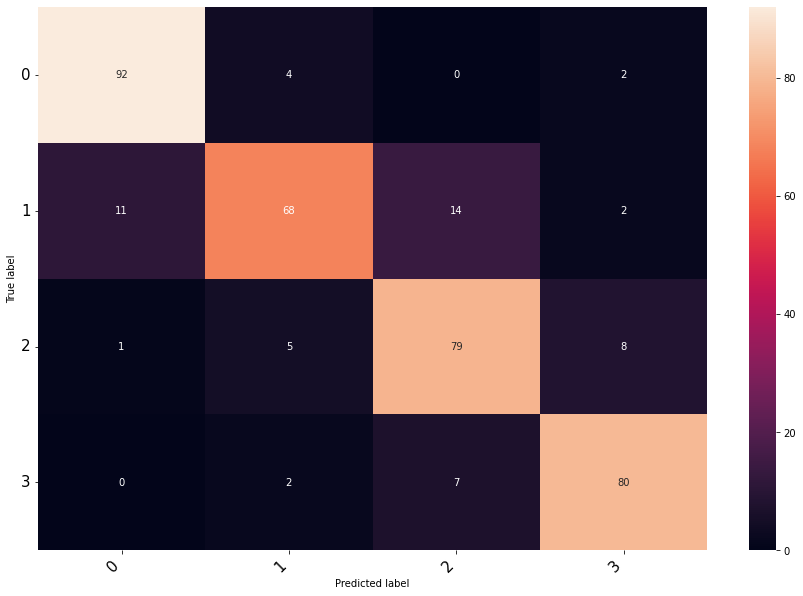

In [47]:
cm.visualize()

In [48]:
cm.class_accuracy

tensor([0.9388, 0.7158, 0.8495, 0.8989])

### GAT

In [49]:
save_model = f'{save_path}_gat'
log_dir = f'{log_path}_gat'

add_self_loop = True

dataset_val = ContagionDataset(
    raw_dir=data_dir,
    drop_edges=0,
    sets_lengths=sets_lengths,
    add_self_loop = add_self_loop,
    target = target,
)

gat_model = dict(
    in_features = [len(dataset.node_attributes)],
    h_features = [[10], [10] * 2, [15], [15] * 2, [20], [20] * 2, [25], [25] * 2],
    out_features = [out_feats],
    num_heads = [[4] * 2, [2] * 2, [4, 2]],
    norm_nodes = [None, 'bn', 'gn'],
    activation = [torch.nn.ReLU()],
    negative_slope = [0.2, 0.4],
    feat_drop = [0.2],
    attn_drop = [0.2],
    residual = [True],
    # other
    lr=[1e-2,],
    label_smoothing=[0.0, 0.2],
    use_edge_weight=[True],
    drop_edges=[0,0.2],
)
list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]

# gat_model = dict(
#     in_features = [len(dataset.node_attributes)],
#     # h_features = [[10], [15], [20]], 
#     h_features = [[10] * 3, [15] * 3, [20] * 3], 
#     out_features = [out_feats],
#     # num_heads = [[4] * 4],
#     num_heads = [[4, 2, 2]],
#     norm_nodes = [None, 'bn', 'gn'],
#     activation = [torch.nn.ReLU()],
#     negative_slope = [0.2, 0.3, 0.4],
#     feat_drop = [0.2],
#     attn_drop = [0.2],
#     residual = [True],
#     # other
#     lr=[1e-2,],
#     label_smoothing=[0.0],
#     use_edge_weight=[False],
#     drop_edges=[0,],
# )
# list_model = [dict(zip(gat_model.keys(), k)) for k in itertools.product(*gat_model.values())]
# list_model = [{i:j[k] for i,j in gat_model.items()} for k in range(len(gat_model['in_features']))]

In [50]:
if do_train:
    for d in tqdm(list_model):
        d = d.copy()
        lr = d.pop('lr')
        ls = d.pop('label_smoothing')
        drop_edges = d.pop('drop_edges')
        use_edge_weight = d.pop('use_edge_weight')

        # dataset_valid = ContagionDataset(
        #     raw_dir=data_dir,
        #     drop_edges=0,
        #     sets_lengths=sets_lengths,
        #     add_self_loop = add_self_loop,
        #     target = target,
        #     seed=seed,
        # )

        dataset_train = ContagionDataset(
            raw_dir=data_dir,
            drop_edges=drop_edges,
            sets_lengths=sets_lengths,
            add_self_loop = add_self_loop,
            target = target,
        )

        train(
            model=GAT(**d),
            dict_model=d,
            dataset_train=dataset_train,
            dataset_val=dataset_val,
            log_dir=log_dir,
            save_path=save_model,
            lr=lr,
            optimizer_name="adamw",
            n_epochs=100,
            scheduler_mode='max_val_mcc',
            debug_mode=False,
            steps_save=10,
            use_cpu=False,
            label_smoothing=ls,
            use_edge_weight=use_edge_weight,
        )

#### Results

In [51]:
res_edges_gat = test(
    dataset=dataset_val,
    save_path=save_model,
    n_runs=1,
    debug_mode=False,
    use_cpu=False,
    save=True,
    use_edge_weight=True,
)

100%|██████████| 11549/11549 [08:28<00:00, 22.70it/s]


In [65]:
res_edges = res_edges_gat
res_edges[0]

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1356635,
 'train_acc': 0.5933333039283752,
 'val_acc': 0.5946666598320007,
 'epoch': 98,
 'model_class': 'gat',
 'path_name': '0.59_4_[20]_4_[4_4]_bn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_10_True_0',
 'train_mcc': 0.45879996908854886,
 'val_mcc': 0.46179314818883843,
 'test_mcc': 0.3713696408029781,
 'train_rmse': 0.8422192905255337,
 'val_rmse': 0.816496580927726,
 'test_rmse': 0.9633275663033837,
 'test_acc': 0.527999997138977}

In [66]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_1] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1526488,
 'train_acc': 0.590666651725769,
 'val_acc': 0.6000000238418579,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '0.60_4_[20]_4_[4_4]_bn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_10_True_0_100',
 'train_mcc': 0.4556118412536823,
 'val_mcc': 0.46940059191768263,
 'test_mcc': 0.3717223258144758,
 'train_rmse': 0.8547904226573123,
 'val_rmse': 0.8181279443542638,
 'test_rmse': 0.9465727652959386,
 'test_acc': 0.527999997138977}

In [67]:
all = res_edges[2]
# ascending order
sort_idx = np.argsort([k['dict'][metric_filter_2] for k in all])[::-1]
all[sort_idx[0]]['dict']

{'in_features': 4,
 'h_features': [20],
 'out_features': 4,
 'num_heads': [4, 4],
 'norm_nodes': 'bn',
 'activation': ReLU(),
 'negative_slope': 0.2,
 'feat_drop': 0.2,
 'attn_drop': 0.2,
 'residual': True,
 'train_lr': 0.01,
 'train_optimizer_name': 'adamw',
 'train_scheduler_mode': 'max_val_mcc',
 'train_label_smoothing': 0.0,
 'train_use_edge_weight': True,
 'train_scheduler_patience': 10,
 'train_self_loop': True,
 'train_drop_edges': 0,
 'train_loss': 1.1526488,
 'train_acc': 0.590666651725769,
 'val_acc': 0.6000000238418579,
 'epoch': 100,
 'model_class': 'gat',
 'path_name': '0.60_4_[20]_4_[4_4]_bn_ReLU()_0.2_0.2_0.2_True_0.01_adamw_max_val_mcc_0.0_True_10_True_0_100',
 'train_mcc': 0.4556118412536823,
 'val_mcc': 0.46940059191768263,
 'test_mcc': 0.3717223258144758,
 'train_rmse': 0.8547904226573123,
 'val_rmse': 0.8181279443542638,
 'test_rmse': 0.9465727652959386,
 'test_acc': 0.527999997138977}

In [68]:
pretty([all[k]['dict'] for k in sort_idx])

100%|██████████| 11549/11549 [00:00<00:00, 30232.48it/s]


In [69]:
cm = all[sort_idx[0]]['test_cm'][0]

In [70]:
(cm.labels==0).sum()

tensor(98)

<module 'matplotlib.pyplot' from 'c:\\Users\\vibal\\PycharmProjects\\systemic-risk-predictor\\venv\\lib\\site-packages\\matplotlib\\pyplot.py'>

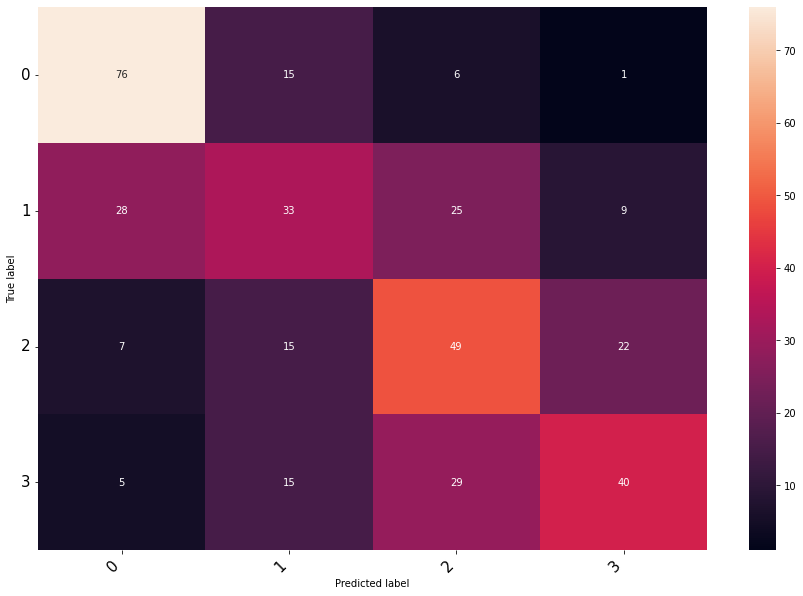

In [71]:
cm.visualize()

In [72]:
cm.class_accuracy

tensor([0.7755, 0.3474, 0.5269, 0.4494])